run this notebook with the `gayles` conda environment

In [1]:
SEED = 1
import random

import tellurium as te
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import logging
logging.getLogger("cobra").setLevel(logging.ERROR)

import os

from scipy import stats
import scipy as sp
import math

import cloudpickle
import gzip

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
os.chdir('../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyC')

In [3]:
ant = '../../models/Antimony/TopologyC_1.ant'  
r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.1827489929340788e-13

In [4]:
data_file01 = '../../data/interim/generated_data/topologyC_1/TopologyC_1_0.1.csv'
BMCA_obj01 = antemll.antemll(ant, data_file01, cobra_sbml='../../models/sbml/TopologyC_1_cobra.xml')


../../models/Antimony/TopologyC_1_cobra.ant


No objective coefficients in model. Unclear what should be optimized


## Running ADVI

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\tensor\elemwise.py:788: RuntimeWarning:

divide by zero encountered in log



Text(0, 0.5, 'Probability density')

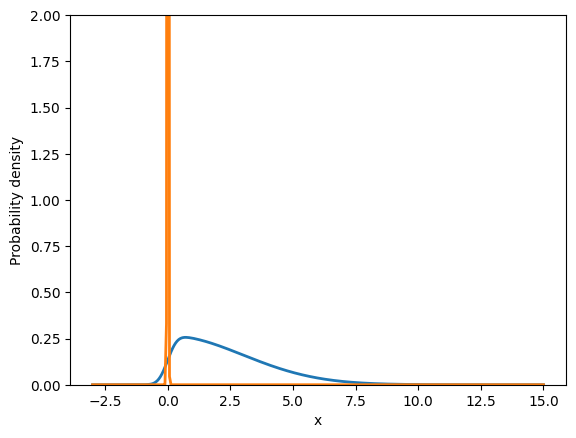

In [5]:
normal_dist = pm.HalfNormal.dist(sigma=1)

s_dist = pm.SkewNormal.dist(mu=0, sigma=3, alpha=10)
t_dist = pm.Laplace.dist(mu=0, b=0.01)
# b=0.01, alpha=5, sd=1

x_eval = np.linspace(-3, 15, 300)
plt.plot(x_eval, at.exp(pm.logp(s_dist,x_eval)).eval(), lw=2.)
plt.plot(x_eval, at.exp(pm.logp(t_dist,x_eval)).eval(), lw=2.)


plt.ylim([0, 2])

plt.xlabel('x')
plt.ylabel('Probability density')

In [6]:
def run_ADVI(BMCA_obj):
    np.random.seed(SEED)
    random.seed(SEED)



    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex', sd=3, alpha=10))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        # likelihood = e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs))
        v_hat_obs = pm.Laplace('v_hat_obs', mu=likelihood, b=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 40000 #150000
    
    with pymc_model:
        advi = pm.ADVI(random_seed=SEED)
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-2), 
            total_grad_norm_constraint=1,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    with pymc_model:
        trace = approx.sample(draws=1000, random_seed=SEED)
        ppc_vi = pm.sample_posterior_predictive(trace)

    return approx, trace, ppc_vi

In [ ]:
approx, trace01, ppc01 = run_ADVI(BMCA_obj01)

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log



In [ ]:
with gzip.open("../../data/results/tracePickles/topologyC-alldata_just1-Exdistr.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace01":trace01,
                "ppc01":ppc01
                },
                f,
            )

## Analysis

In [10]:
picklefolder = '../../data/results/tracePickles/'
with gzip.open(picklefolder + 'topologyC-alldata_1-5.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

trace_a=traces['trace01']
ppc_a=traces['ppc01']

In [11]:
picklefolder = '../../data/results/tracePickles/'
with gzip.open(picklefolder + 'topologyC-alldata_just1.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

trace_b=traces['trace01']
ppc_b=traces['ppc01']

In [ ]:
picklefolder = '../../data/results/tracePickles/'
with gzip.open(picklefolder + 'topologyC-alldata_just1-Exdistr.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

trace_c=traces['trace01']
ppc_c=traces['ppc01']

#### Known flux and metabolite concentrations check

In [13]:
v_ppc_a = az.summary(ppc_a['posterior_predictive']['v_hat_obs'])['mean']
vn_a = az.summary(trace_a['posterior']['vn'])['mean']

v_ppc_b = az.summary(ppc_b['posterior_predictive']['v_hat_obs'])['mean']
vn_b = az.summary(trace_b['posterior']['vn'])['mean']

v_ppc_c = az.summary(ppc_c['posterior_predictive']['v_hat_obs'])['mean']
vn_c = az.summary(trace_c['posterior']['vn'])['mean']

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


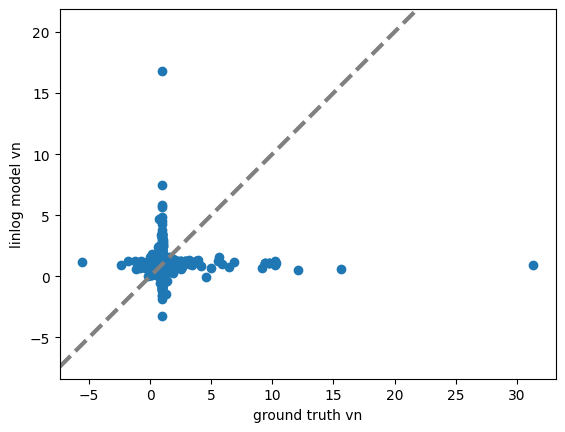

In [ ]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(BMCA_obj01.vn.values.ravel(), vn_a)
plt.xlabel('ground truth vn')
plt.ylabel('linlog model vn')
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)

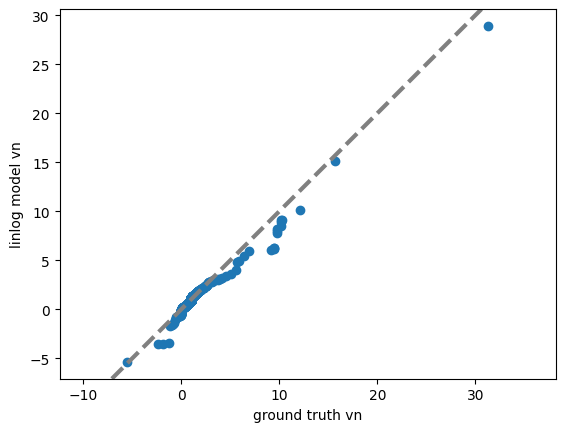

In [ ]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(np.sort(BMCA_obj01.vn.values.ravel()), np.sort(vn_a))
plt.xlabel('ground truth vn')
plt.ylabel('linlog model vn')
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)


Text(0.5, 0.98, 'vn comparisons')

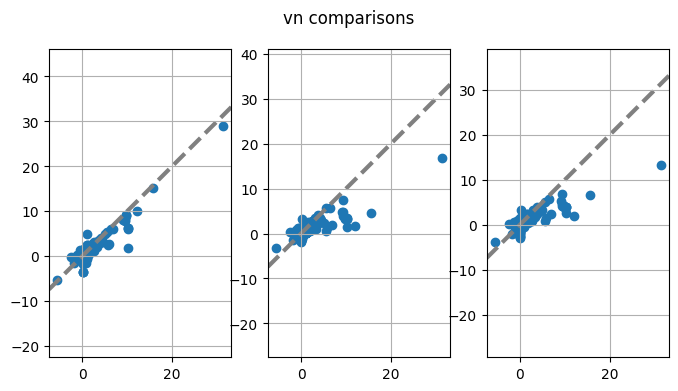

In [27]:
f, ax = plt.subplots(1, 3, figsize=(8,4))

ax[0].scatter(BMCA_obj01.vn.values, vn_a.values.reshape((68,67)).T)
ax[0].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[0].set_aspect('equal', 'datalim')
ax[0].grid()

ax[1].scatter(BMCA_obj01.vn.values, vn_b.values.reshape((68,67)).T)
ax[1].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[1].set_aspect('equal', 'datalim')
ax[1].grid()

ax[2].scatter(BMCA_obj01.vn.values, vn_c.values.reshape((68,67)).T)
ax[2].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[2].set_aspect('equal', 'datalim')
ax[2].grid()

plt.suptitle('vn comparisons')

Text(0.5, 0.98, 'v_obs comparisons')

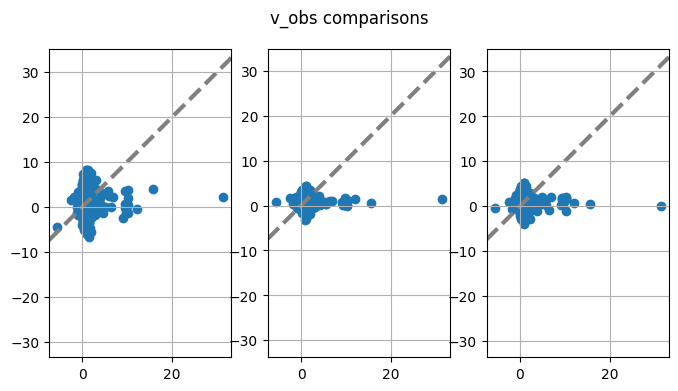

In [28]:
f, ax = plt.subplots(1, 3, figsize=(8,4))

ax[0].scatter(BMCA_obj01.vn.values, v_ppc_a.values)
ax[0].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[0].set_aspect('equal', 'datalim')
ax[0].grid()

ax[1].scatter(BMCA_obj01.vn.values, v_ppc_b.values)
ax[1].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[1].set_aspect('equal', 'datalim')
ax[1].grid()

ax[2].scatter(BMCA_obj01.vn.values, v_ppc_c.values)
ax[2].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[2].set_aspect('equal', 'datalim')
ax[2].grid()

plt.suptitle('v_obs comparisons')

In [29]:
Ex_a = util.get_az_summary(trace_a)
Ex_b = util.get_az_summary(trace_b)
Ex_c = util.get_az_summary(trace_c)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [33]:
pt_labels = ['gt','a','b','c']

In [34]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten(), 
                                     Ex_a, Ex_b, Ex_c])

elasticities_df = pd.DataFrame(elasticity_values, columns=pt_labels,
                               index=[i + '^' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])

In [35]:
e_slopes = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[0],3) for i in pt_labels]
e_intercepts = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[1],3) for i in pt_labels]
e_r2s = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[2],3) for i in pt_labels]

(-10.0, 10.0)

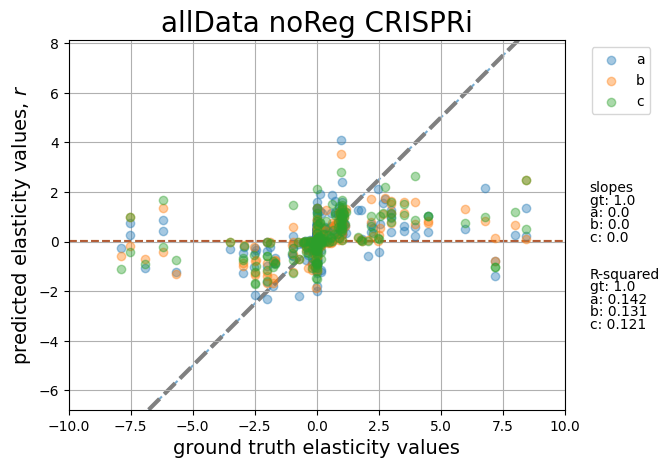

In [40]:
plt.axes().set_aspect('equal', 'datalim')

plt.scatter(elasticities_df['gt'], elasticities_df['a'], alpha=0.4, label='a', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['b'], alpha=0.4, label='b', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['c'], alpha=0.4, label='c', zorder=10)


plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title('allData noReg CRISPRi', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 11
line_spacing = 0.5
slope_start = 2
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(len(pt_labels)):
    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

plt.xlim(-10,10)

Text(0.5, 0.98, 'Ex comparisons')

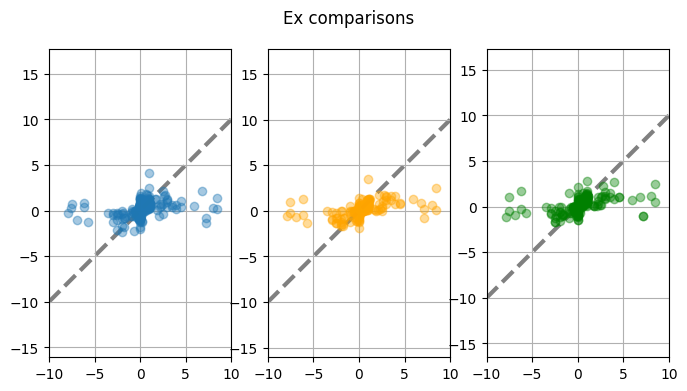

In [48]:
f, ax = plt.subplots(1, 3, figsize=(8,4))

ax[0].scatter(elasticities_df['gt'], elasticities_df['a'], alpha=0.4, label='a', zorder=10)
ax[0].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[0].set_aspect('equal', 'datalim')
ax[0].grid()
ax[0].set_xlim((-10,10))

ax[1].scatter(elasticities_df['gt'], elasticities_df['b'], alpha=0.4, label='b', zorder=10, c='orange')
ax[1].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[1].set_aspect('equal', 'datalim')
ax[1].grid()
ax[1].set_xlim((-10,10))

ax[2].scatter(elasticities_df['gt'], elasticities_df['c'], alpha=0.4, label='c', zorder=10, c='g')
ax[2].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
ax[2].set_aspect('equal', 'datalim')
ax[2].grid()
ax[2].set_xlim((-10,10))

plt.suptitle('Ex comparisons')

In [47]:
elasticities_df[abs(elasticities_df['c']) > 5]

,gt,a,b,c
